
 Joshua W. von Nonn \
 Geographer \
 U.S. Geological Survey \
 Western Geographic Science Center \
 P.O. Box 158 \
 Moffett Field, CA 94035 \
 Email: jvonnonn@usgs.gov 

# SfM RGB Point cloud processing with PDAL

The following code in this notebook will classify ground points and generate a DTM.\
PDAL documentation: https://pdal.io/en/latest/

<mark style="background-color: #FFFFCC"> Prior to running this notebook, the point cloud should have the outliers removed and thinned using PDAL's Poisson. I recommend a radius of 0.25 to start, but this will depend on your objective, microtopography, and the intended DTM resolution. <mark>

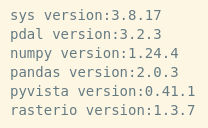

In [2]:
import sys
import pdal
import numpy as np
import pandas as pd
import pyvista as pv
import rasterio as rio

print(f"sys version:{sys.version[:6]}")
print(f"pdal version:{pdal.__version__}")
print(f"numpy version:{np.__version__}")
print(f"pandas version:{pd.__version__}")
print(f"pyvista version:{pv.__version__}")
print(f"rasterio version:{rio.__version__}")

sys version:3.8.17
pdal version:3.2.3
numpy version:1.24.4
pandas version:2.0.3
pyvista version:0.41.1
rasterio version:1.3.7


In [3]:
#normalizing band color values for pyvist
def normalizing(dflist):
    dflist_norm = (dflist - dflist.min()) / (dflist.max() - dflist.min())
    return(dflist_norm)

In [4]:
#enter absolute path of laz or las file, example: fp = '/home/user/Downloads/points.laz'
fp = '/media/grendel/AE10528B10525B03/UAS_2021_Sonoma_Fires/GLA3_2021/WebODM/1cm_products/Glass_ultra_croped_and_thinned_olr_rmvd_byhand.las'

In [5]:
#reading las file into pdal pipeline
p = pdal.Reader.las(fp).pipeline()
n_pts = p.execute()

f'Pipeline selected {n_pts} points'

'Pipeline selected 633600 points'

In [6]:
#uncomment to thin point cloud to 25cm radius
#p = pdal.Filter.sample(radius=0.25).pipeline(p.arrays[0])
#p.execute()

#### To iterate, set the parameters for the algorithm of your choice then skip to "Setting viz parameters"

In [10]:
#smrf parameters ---- settings for complex topography

cell = 1
window = 13
scalar = 1.5
slope = 0.35
threshold = 0.5

ground_test = pdal.Filter.smrf(cell=cell,window=window,scalar=scalar,slope=slope,threshold=threshold).pipeline(p.arrays[0])
ground_test.execute()

633600

In [ ]:
#PMF ----- aggressive parameters for flat topography, i.e. meadow

cell_size = 1
max_w = 33
slope = .05 #
initial_dist = 0.05
max_dist = 2

ground_test = pdal.Filter.pmf(cell_size=cell_size,max_window_size=max_w,slope=slope,
                              initial_distance=initial_dist,max_distance=max_dist).pipeline(p.arrays[0])
ground_test.execute()

In [ ]:
#cloth ---- default settings

resolution = 1
threshold = 0.5
step = 0.65
rigidness = 3

ground_test = pdal.Filter.csf(resolution=resolution, threshold=threshold, step=step,
                               rigidness=rigidness).pipeline(p.arrays[0])
ground_test.execute()


### Setting viz parameters

In [8]:
arr = ground_test.arrays[0]
cols = [col for col, _ in arr.dtype.descr]

df = pd.DataFrame({col: arr[col] for col in cols})

bands = ("Red","Green","Blue")
for band in bands:
    df[band] = normalizing(df[band])

df.loc[df['Classification'] == 2, bands] = (0.98,0.78,0.44) #colorizing ground points

pc_norm = np.dstack((df.X, df.Y, df.Z,))
pc_colors = np.dstack((df.Red, df.Green, df.Blue))

pc_norm = pc_norm.reshape(pc_norm.shape[1], pc_norm.shape[2])
pc_colors = pc_colors.reshape(pc_colors.shape[1], pc_colors.shape[2])

pcn = pv.PolyData(pc_norm)
pcn['colors'] = pc_colors

f'{len(df[df.Classification == 2])} ground points found.'

'535024 ground points found.'

### Plot will pop-out window

In [9]:
pcn.plot(scalars='colors', point_size=2, rgb=True, notebook=False, full_screen=True)

### Write out DTM
https://pdal.io/en/2.6.0/stages/writers.gdal.html


<mark style="background-color: #FFFFCC"> The DTM will likely have no-data holes. I recommend the GDAL fill no-data tool in QGIS to resolve these. <mark>

In [ ]:
#selecting only ground points to generate DTM
#resolution here is set to 50cm
#DTM will be written to same location as this notebook

DTM = (pdal.Filter.range(limits="Classification[2:2]").pipeline(ground_test.arrays[0]) |
      pdal.Writer.gdal(resolution = 0.5, radius = 1, output_type='min', filename="DTM_test.tif").pipeline())
DTM.execute()